In [3]:
import xarray as xr
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.ndimage import label

# 1. Downloading the ERA5 precipitation daily statistics data from the ECMWF CDS. 
> **Note** While this code ran effectively, because it was a for loop it would not submit the next request until the previous one had returned the data. Because I got stuck in the CDS request queue, I manually submitted the data requests for roughly 1960-2025 by adjusting the dates and running the code block iteratively. 

```python
# This code block has been changed to a code-rendered markdown cell so that the workflow can be preserved without sending duplicate data requests.

import cdsapi
client = cdsapi.Client()


In [65]:
# This code block has been changed to a code-rendered markdown cell so that the workflow can be preserved without sending duplicate data requests.

dataset = "derived-era5-single-levels-daily-statistics"

for year in range(2013, 2014):  # inclusive of 2024
    print(f"Requesting data for {year}...")

    request = {
        "product_type": "reanalysis",
        "variable": ["total_precipitation"],
        "year": str(year),
        "month": [
            "01", "02", "03", "04", "05", "06",
            "07", "08", "09", "10", "11", "12"
        ],
        "day": [
            "01", "02", "03", "04", "05", "06",
            "07", "08", "09", "10", "11", "12",
            "13", "14", "15", "16", "17", "18",
            "19", "20", "21", "22", "23", "24",
            "25", "26", "27", "28", "29", "30", "31"
        ],
        "daily_statistic": "daily_sum",
        "time_zone": "utc-07:00",
        "frequency": "1_hourly",
        "area": [40, -123, 36, -119],  # N, W, S, E
        "format": "netcdf"
    }

    filename = f"../signal-extraction-data/Reanalysis/ERA5_pr_dat/{year}.nc"
    client.retrieve(dataset, request).download(filename)


Requesting data for 2013...


2025-07-18 17:11:18,928 INFO Request ID is 9fea5f2b-ad86-4402-82a9-0650a1d18e94
2025-07-18 17:11:19,062 INFO status has been updated to accepted
2025-07-18 17:11:52,276 INFO status has been updated to running
2025-07-18 17:25:40,943 INFO status has been updated to successful


45610e561b08b5f3506f1ec537a58a14.nc:   0%|          | 0.00/113k [00:00<?, ?B/s]

# 2. Concatenating the downloaded netcdfs into a single `.nc` file
> **Note** I will use the CDO command line tool for concatenating these files because it is fast and efficient.

In [72]:
# Note that this code generated the error "cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!". I ignored this error because the dataset loaded into xarray correctly in the subsequent steps.

!cdo mergetime $(seq 1940 2025 | sed 's|^|/Users/julianesler/Documents/Columbia/CWC_Research/signal-extraction/signal-extraction-data/Reanalysis/ERA5_pr_dat/|;s|$|.nc|') tp_day-stat.nc

cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!
cdi  warning (set_coordinates_varids): Coordinates var

# 3. Extracting the monthly maximum event time series

>**warning** To run the other preprocessing code sections, run the data loading cell in this section.

### (A) Loading the data

In [68]:
two013 = xr.open_dataset("../signal-extraction-data/Reanalysis/ERA5_pr_dat/2011.nc")
two013

<xarray.Dataset> Size: 425kB
Dimensions:     (valid_time: 365, latitude: 17, longitude: 17)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 136B 40.0 39.75 39.5 ... 36.5 36.25 36.0
  * longitude   (longitude) float64 136B -123.0 -122.8 -122.5 ... -119.2 -119.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2011-01-01 ... 2011-12-31
Data variables:
    tp          (valid_time, latitude, longitude) float32 422kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-10T06:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [74]:
#loading the data
tpdat = xr.open_dataset("../signal-extraction-data/Reanalysis/tp_day-stat.nc")
tpdat

<xarray.Dataset> Size: 36MB
Dimensions:     (valid_time: 31228, latitude: 17, longitude: 17)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 250kB 1940-01-01 ... 2025-06-30
  * longitude   (longitude) float64 136B -123.0 -122.8 -122.5 ... -119.2 -119.0
  * latitude    (latitude) float64 136B 40.0 39.75 39.5 ... 36.5 36.25 36.0
Data variables:
    tp          (valid_time, latitude, longitude) float32 36MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.1 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 18 18:19:24 2025: cdo mergetime /Users/j...
    CDO:                     Climate Data Operators version 2.5.1 (https://mp...

### (B) Exploratory data analysis to verify data integrity

In [4]:
"""
Doing some exploratory data analysis to understand the data and its distribution a little bit. 
"""
# Select your variable (replace 'tp' if needed)
prec = tpdat['tp'] if 'tp' in tpdat.data_vars else list(tpdat.data_vars.values())[0]
precip = prec.stack(gridcell=('latitude', 'longitude'))
# Compute standard reductions
mean_precip = precip.mean(dim='valid_time', skipna=True)
min_precip = precip.min(dim='valid_time', skipna=True)
max_precip = precip.max(dim='valid_time', skipna=True)
std_precip = precip.std(dim='valid_time', skipna=True)
median_precip = precip.median(dim='valid_time', skipna=True)

# Compute skew using apply_ufunc
skew_precip = xr.apply_ufunc(
    skew,
    precip,
    input_core_dims=[['valid_time']],
    vectorize=True,
    kwargs={'nan_policy': 'omit'},
    dask='parallelized',  # if using dask arrays
    output_dtypes=[float],
)

# Combine all into one Dataset
summary_stats = xr.Dataset({
    'mean_precip': mean_precip,
    'min_precip': min_precip,
    'max_precip': max_precip,
    'std_precip': std_precip,
    'skew_precip': skew_precip,
    'median_precip': median_precip
})

# Optional: inspect or save
print(summary_stats)
# summary_stats.to_netcdf('precip_summary_stats.nc')
print(len(summary_stats['mean_precip']))

<xarray.Dataset> Size: 16kB
Dimensions:        (gridcell: 289)
Coordinates:
  * gridcell       (gridcell) object 2kB MultiIndex
  * latitude       (gridcell) float64 2kB 40.0 40.0 40.0 40.0 ... 36.0 36.0 36.0
  * longitude      (gridcell) float64 2kB -123.0 -122.8 -122.5 ... -119.2 -119.0
Data variables:
    mean_precip    (gridcell) float32 1kB 0.002915 0.002213 ... 0.00108 0.00136
    min_precip     (gridcell) float32 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    max_precip     (gridcell) float32 1kB 0.1355 0.1001 ... 0.05959 0.07988
    std_precip     (gridcell) float32 1kB 0.007723 0.00625 ... 0.003746 0.004341
    skew_precip    (gridcell) float64 2kB 4.549 4.67 4.793 ... 5.969 5.389 5.245
    median_precip  (gridcell) float64 2kB 1.431e-06 0.0 0.0 0.0 ... 0.0 0.0 0.0
289


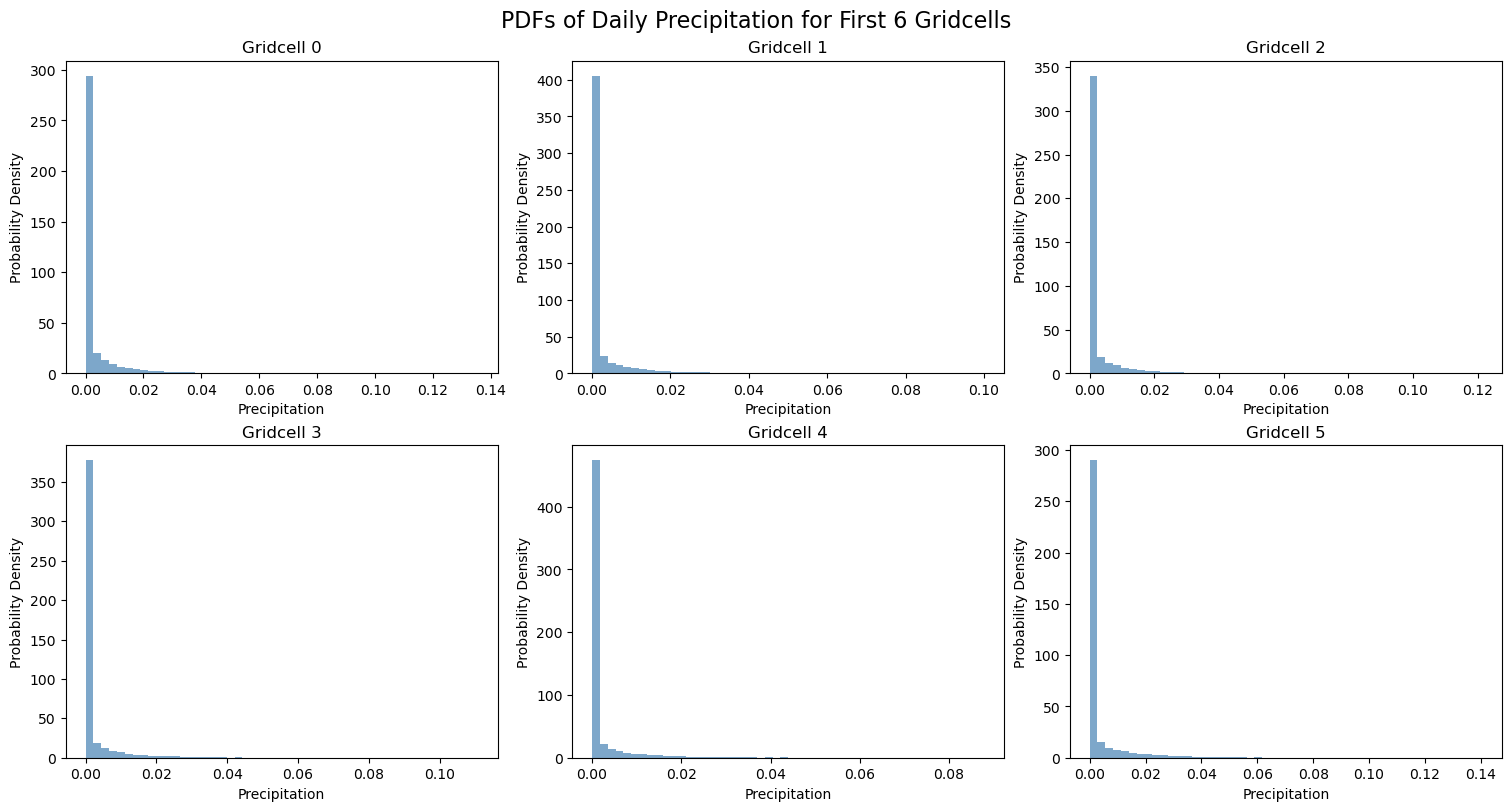

In [5]:
# Select variable (change 'tp' if needed)
rpr = tpdat['tp'] if 'tp' in tpdat.data_vars else list(tpdat.data_vars.values())[0]

# Flatten spatial dimensions
precip_flat = rpr.stack(gridcell=('latitude', 'longitude'))

# Plot PDFs for first 6 grid cells
n_cells = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

for i in range(n_cells):
    ax = axes.flat[i]
    
    data = precip_flat.isel(gridcell=i).values
    data = data[np.isfinite(data)]  # remove NaNs

    ax.hist(data, bins=50, density=True, alpha=0.7, color='steelblue')
    ax.set_title(f"Gridcell {i}")
    ax.set_xlabel("Precipitation")
    ax.set_ylabel("Probability Density")

plt.suptitle("PDFs of Daily Precipitation for First 6 Gridcells", fontsize=16)
plt.show()


### (C) Extracting events from the daily timeseries

In [75]:
'''
Extracting the precipitation events from the daily data. In this method, the data is threshhold-masked for precipitation >0.001m,
and then the scipy.ndimage label() function is used to assign consecutive blocks of precipitation an integer event id. These labels are
then merged with the precipitation values so that each precipitation cell is associated with a precipiation event.
'''
prip = tpdat['tp']  # 3D DataArray with dims: valid_time, latitude, longitude

# 📌 Define wet day threshold
threshold_m = 0.001
wet_days = prip > threshold_m

# 🎯 Label precipitation events (consecutive wet days) for each grid cell
labeled_events = xr.apply_ufunc(
    lambda x: label(x)[0],
    wet_days,
    input_core_dims=[["valid_time"]],
    output_core_dims=[["valid_time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int]
)

# 📦 Convert to tidy DataFrame format
df_precip = prip.to_dataframe(name="precip").reset_index()
df_labels = labeled_events.to_dataframe(name="event_id").reset_index()


# ⏱️ Extract month and year from valid_time
df_precip["month"] = pd.to_datetime(df_precip["valid_time"]).dt.month
df_precip["year"] = pd.to_datetime(df_precip["valid_time"]).dt.year
df_labels["month"] = pd.to_datetime(df_labels["valid_time"]).dt.month
df_labels["year"] = pd.to_datetime(df_labels["valid_time"]).dt.year

# 🔗 Merge the precipitation values with event labels
df = pd.merge(df_precip, df_labels, on=["valid_time", "latitude", "longitude", "month", "year"])

# 🧹 Drop non-event entries (event_id == 0 means dry days or not part of a wet spell)
df = df[df["event_id"] > 0]

# 📊 Group by each unique (lat, lon, event) combination
event_df = (
    df.groupby(["latitude", "longitude", "event_id", "month", "year"])
      .agg(
          start_time=("valid_time", "min"),
          end_time=("valid_time", "max"),
          duration_days=("valid_time", "count"),
          tp_m=("precip", "sum")
      )
      .reset_index()
)

event_ds = xr.Dataset.from_dataframe(event_df.set_index(["latitude", "longitude", "event_id", "year", "month"]))

In [76]:
event_ds

<xarray.Dataset> Size: 30GB
Dimensions:        (latitude: 17, longitude: 17, event_id: 3649, year: 86,
                    month: 12)
Coordinates:
  * latitude       (latitude) float64 136B 36.0 36.25 36.5 ... 39.5 39.75 40.0
  * longitude      (longitude) float64 136B -123.0 -122.8 ... -119.2 -119.0
  * event_id       (event_id) int64 29kB 1 2 3 4 5 ... 3645 3646 3647 3648 3649
  * year           (year) int32 344B 1940 1941 1942 1943 ... 2022 2023 2024 2025
  * month          (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    start_time     (latitude, longitude, event_id, year, month) datetime64[ns] 9GB ...
    end_time       (latitude, longitude, event_id, year, month) datetime64[ns] 9GB ...
    duration_days  (latitude, longitude, event_id, year, month) float64 9GB 4...
    tp_m           (latitude, longitude, event_id, year, month) float32 4GB 0...

>**note** The event_ds dataset can be used for future event disagreggation because it contains potentially relevant statistics like event frequency and duration.

### (D) Extracting the monthly maximum event

In [77]:
'''
Extracting the monthly maximum event from the events time series. This is done simply by grouping the precipitation timeseries by lat,
lon, month, and year and then taking the maximum.
'''
max_monthly_event = event_ds['tp_m'].groupby(['latitude', 'longitude', 'year', 'month']).max(dim='event_id')

# Step 3: Optionally convert to Dataset and name
max_event_ds = max_monthly_event.to_dataset(name="max_event_tp")


>**warning** I believe that this method of monthly maximum event extraction is prone to assigning a single event to multiple months if that even straddles multiple months.

```python
#event_ds.to_netcdf("../signal-extraction-data/Reanalysis/tp_events.nc") # Note that the event_ds.nc was a 29GB file so I deleted it lol.
max_event_ds.to_netcdf("../signal-extraction-data/Reanalysis/tp_mon_event-max.nc")


# 4. Extracting the monthly sum time series

In [80]:
tpdat = tpdat.assign_coords(
    month=tpdat.valid_time.dt.month,
    year=tpdat.valid_time.dt.year
)

In [81]:
tpdat

<xarray.Dataset> Size: 37MB
Dimensions:     (valid_time: 31228, latitude: 17, longitude: 17)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 250kB 1940-01-01 ... 2025-06-30
  * longitude   (longitude) float64 136B -123.0 -122.8 -122.5 ... -119.2 -119.0
  * latitude    (latitude) float64 136B 40.0 39.75 39.5 ... 36.5 36.25 36.0
    month       (valid_time) int64 250kB 1 1 1 1 1 1 1 1 1 ... 6 6 6 6 6 6 6 6 6
    year        (valid_time) int64 250kB 1940 1940 1940 1940 ... 2025 2025 2025
Data variables:
    tp          (valid_time, latitude, longitude) float32 36MB 0.01989 ... 0.0
Attributes:
    CDI:                     Climate Data Interface version 2.5.1 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 18 18:19:24 2025: cdo mergetime /Users/j...
    CDO:                     Climate Data Operators version 2.5.1 (https://mp...

In [82]:
monthly_sum = tpdat.groupby(['year', 'month']).sum(dim='valid_time')

```python
monthly_sum.to_netcdf('../signal-extraction-data/Reanalysis/tp_mon-sum.nc')


In [6]:
monsum = xr.open_dataset('../signal-extraction-data/Reanalysis/tp_mon-sum.nc')
print(monsum)

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 17, longitude: 17, year: 86, month: 12)
Coordinates:
  * longitude  (longitude) float64 136B -123.0 -122.8 -122.5 ... -119.2 -119.0
  * latitude   (latitude) float64 136B 40.0 39.75 39.5 39.25 ... 36.5 36.25 36.0
  * year       (year) int64 688B 1940 1941 1942 1943 ... 2022 2023 2024 2025
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tp         (latitude, longitude, year, month) float32 1MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.1 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 18 18:19:24 2025: cdo mergetime /Users/j...
    CDO:                     Climate Data Operators version 2.5.1 (https://mp...


In [9]:
monsum_flat = monsum.tp.stack(time=("year","month"))
monsum_flat = monsum_flat.reset_index('time')
print(monsum_flat)

<xarray.DataArray 'tp' (latitude: 17, longitude: 17, time: 1032)> Size: 1MB
array([[[0.23085856, 0.3596363 , 0.19333577, ...,        nan,
                nan,        nan],
        [0.20495057, 0.29238963, 0.13812947, ...,        nan,
                nan,        nan],
        [0.22209692, 0.34618354, 0.16997147, ...,        nan,
                nan,        nan],
        ...,
        [0.06295061, 0.05648088, 0.03407812, ...,        nan,
                nan,        nan],
        [0.05581045, 0.04425669, 0.02894163, ...,        nan,
                nan,        nan],
        [0.05230236, 0.03684425, 0.02627778, ...,        nan,
                nan,        nan]],

       [[0.22123241, 0.35044837, 0.18198204, ...,        nan,
                nan,        nan],
        [0.20299149, 0.3063221 , 0.14259529, ...,        nan,
                nan,        nan],
        [0.20384645, 0.30651045, 0.13852143, ...,        nan,
                nan,        nan],
...
        [0.10909843, 0.11935401, 0.075890

In [10]:
monsum_flat.to_netcdf('../signal-extraction-data/Reanalysis/monsum_flat.nc')

# 5. Extracting the monthly daily max time series

In [85]:
mon_day_max = tpdat.groupby(['month','year']).max(dim='valid_time')

```python
mon_day_max.to_netcdf('../signal-extraction-data/Reanalysis/tp_mon_day-max.nc')

In [87]:
mondaymax = xr.open_dataset('../signal-extraction-data/Reanalysis/tp_mon_day-max.nc')
mondaymax

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 17, longitude: 17, month: 12, year: 86)
Coordinates:
  * longitude  (longitude) float64 136B -123.0 -122.8 -122.5 ... -119.2 -119.0
  * latitude   (latitude) float64 136B 40.0 39.75 39.5 39.25 ... 36.5 36.25 36.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * year       (year) int64 688B 1940 1941 1942 1943 ... 2022 2023 2024 2025
Data variables:
    tp         (latitude, longitude, month, year) float32 1MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.1 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 18 18:19:24 2025: cdo mergetime /Users/j...
    CDO:                     Climate Data Operators version 2.5.1 (https://mp...

In [27]:
two014 = xr.open_dataset("../signal-extraction-data/Reanalysis/ERA5_pr_dat/2014.nc")
two014

<xarray.Dataset> Size: 425kB
Dimensions:     (valid_time: 365, latitude: 17, longitude: 17)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 136B 40.0 39.75 39.5 ... 36.5 36.25 36.0
  * longitude   (longitude) float64 136B -123.0 -122.8 -122.5 ... -119.2 -119.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    tp          (valid_time, latitude, longitude) float32 422kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-10T10:25 GRIB to CDM+CF via cfgrib-0.9.1...